In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
from pprint import pprint

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

# mapping
import cartopy
import cartopy.crs as ccrs

from matplotlib import colors
import matplotlib.gridspec as gridspec

import pandas as pd
import calendar
import imageio # animation
from helpers import *
from affine import Affine
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)


PyTables is not installed. No support for HDF output.


In [2]:
gldas_fi = '../GLDAS/GLDASp4_domveg_025d.tif'
with rio.open(gldas_fi) as src:
    gldas_prof = src.profile
    gldas_arr = src.read(1)
    
xr_gldas = xr.open_rasterio(gldas_fi)

In [3]:
raster_folder = r"../vars/grid_0_25_degree_vars/" # data refresh!
raster_folder = r"../vars/CSV_nocorn_grid_0_25_degree_vars/" # data refresh! fixed mis classifications
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
year = 2012

day_files, night_files = get_fire_year_files(raster_folder, var, year)

In [4]:
# open and resample to 2.5 deg res
from skimage.transform import resize

with rio.open('../vars/aqua-terra-overpasses-per-day_0.25-degree-grid.tif') as src:
    op_0_25 = src.read()[0]
    print(src.profile)
    
    op_0_25[op_0_25<=0] = 1
    op_0_25_prof = src.profile

with rio.open('../vars/aqua-terra-overpasses-per-day_2.5-degree-grid.tif') as src:
    op_0_2_5 = src.read()[0]
    print(src.profile)
    
    op_0_2_5[op_0_2_5<=0] = 1

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 144, 'height': 72, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.5, 0.0, -178.875,
       0.0, -2.5, 88.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


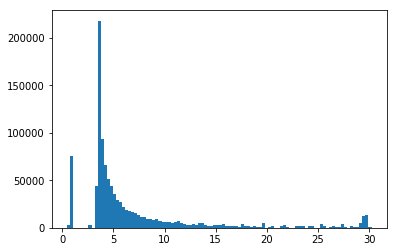

In [5]:
plt.hist(op_0_25[op_0_25>-1].ravel(), bins=100);

In [6]:
days_fl, nights_fl=[],[]
day_an, night_an = [],[]
agg = 4
for year in range(2003,2019):

    day_files = glob(raster_folder + f'{var}/*_D_*{year}.tif')
    night_files = glob(raster_folder + f'{var}/*_N_*{year}.tif')
    
    day_arr,_ = es_stack(day_files, nodata=-32768)
    night_arr, _ = es_stack(night_files, nodata=-32768)
    op_oc = np.ma.masked_equal(op_0_25/365.25/2, 0) # annual overpass average
    
    #day_an.append(day_arr*op_oc)
    #night_an.append(night_arr*op_oc)
    
#     print(day_arr.shape)
#     print((np.ma.sum(day_arr, axis=0)*op_oc).shape)
    
    ds = np.ma.sum(day_arr, axis=0)*op_oc
    ns = np.ma.sum(night_arr, axis=0)*op_oc
    
    day_an.append(ds[np.newaxis,...])
    night_an.append(ns[np.newaxis, ...])
    
    #day_an.append(np.ma.sum(day_arr, axis=0)*op_oc)
    #night_an.append(np.ma.sum(night_arr, axis=0)*op_oc)
    
    # they are different...
    #print(np.ma.mean(day_arr*op_oc - night_arr*op_oc))
    
    continue

In [7]:
day_sum = np.ma.concatenate(day_an, axis=0)
print(day_sum.shape)
day_sum = np.ma.sum(day_sum, axis=0)
night_sum = np.ma.concatenate(night_an, axis=0)
night_sum = np.ma.sum(night_sum, axis=0)

perc_day_total = day_sum / (day_sum + night_sum)
perc_night_total = night_sum / (day_sum + night_sum)

(16, 721, 1440)


In [8]:
tform = op_0_25_prof['transform']
ncols = op_0_25_prof['width']
nrows = op_0_25_prof['height']
agg_fact=1 # 0.25 degree

# template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
# with rio.open(template) as src:
#     meta = src.meta

# tform = meta['transform']
#num_x = meta['width']
#num_y = meta['height']

num_x = night_sum.shape[1]
num_y = night_sum.shape[0]

# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
lon2d, lat2d = np.meshgrid(tlon, tlat)

In [9]:
# make data into xarray with location
xr_nightsum = xr.DataArray(night_sum, coords=[tlat, tlon], dims=['x', 'y'])
xr_nightsum = xr.where(xr_nightsum == 0, np.nan, xr_nightsum)

# make data into xarray with location
xr_daysum = xr.DataArray(day_sum, coords=[tlat, tlon], dims=['x', 'y'])
xr_daysum = xr.where(xr_daysum == 0, np.nan, xr_daysum)

In [10]:
night_sum.shape

(721, 1440)

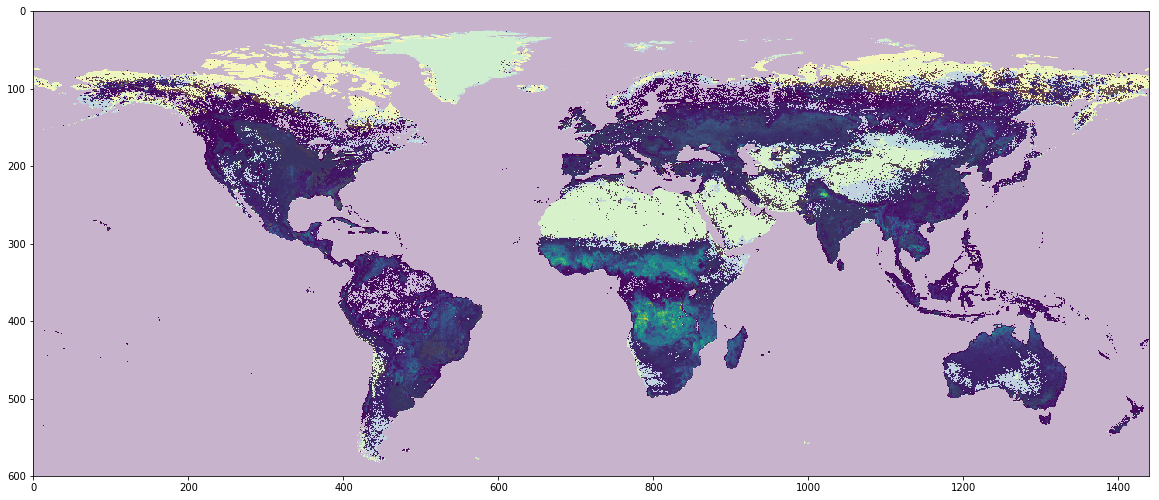

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(xr_daysum.values[:601,:])
plt.imshow(gldas_arr, alpha=0.3)
plt.show()

In [12]:
gl_day = xr_daysum.values[:600,:]
gl_night = xr_nightsum.values[:600,:]

daysum_list, nightsum_list, nightperc_list, cts_list = [],[], [], []
for v in np.unique(gldas_arr):
    
    dsum = np.nansum(np.where(gldas_arr==v, gl_day, np.nan))
    daysum_list.append(dsum)
    
    nsum = np.nansum(np.where(gldas_arr==v, gl_night, np.nan))
    nightsum_list.append(nsum)
    
    nightperc_list.append(nsum / (nsum+dsum))
    
    cts_list.append((gldas_arr==v).sum())

In [67]:
# Index	Vegetation Type
# 0	missing value
# 1	Evergreen Needleleaf Forest 
# 2	Evergreen Broadleaf Forest
# 3	Deciduous Needleleaf Forest 
# 4	Deciduous Broadleaf Forest
# 5	Mixed Forest 
# 6	Closed Shrublands 
# 7	Open Shrublands 
# 8	Woody Savannas
# 9	Savannas
# 10	Grassland
# 11	Permanent Wetland
# 12	Cropland
# 13	Urban and Built-Up
# 14	Cropland/Natural Vegetation Mosaic
# 15	Snow and Ice 
# 16	Barren or Sparsely Vegetated 
# 17	Ocean 
# 18	Wooded Tundra 
# 19	Mixed Tundra 
# 20	Bare Ground Tundra 

gldas_labels = ['missing value',
               'Evergreen Needleleaf Forest',
               'Evergreen Broadleaf Forest',
               'Deciduous Needleleaf Forest',
               'Deciduous Broadleaf Forest',
               'Mixed Forest',
               'Closed Shrublands',
               'Open Shrublands',
               'Woody Savannas',
               'Savannas',
               'Grassland',
               'Permanent Wetland',
               'Cropland',
               'Urban and Built-Up',
               'Cropland / Natural Vegetation Mosaic',
               'Snow and Ice', 
               'Barren or Sparsely Vegetated',
               'Ocean',
               'Wooded Tundra',
               'Mixed Tundra',
               'Bare Ground Tundra']
len(gldas_labels)

21

In [14]:
gldas_dict = {'gldas_label':gldas_labels, 
              'daysum':daysum_list, 
              'nightsum':nightsum_list, 
              'gldas_counts':cts_list, 
              'night_perc':nightperc_list}
gldas_summary = pd.DataFrame(gldas_dict)
# gldas_summary = pd.DataFrame(data=[gldas_labels, daysum_list, nightsum_list, cts_list, nightperc_list],
#                             columns=['gldas_label', 'daysum', 'nightsum', 'gldas_counts', 'night_perc'])

In [15]:
gldas_summary.to_csv('../GLDAS/gldas_025_summary_oc.csv')

In [16]:
gldas_summary.iloc[1:].sort_values('night_perc')

,gldas_label,daysum,nightsum,gldas_counts,night_perc
8,Woody Savannas,79010.335938,5060.659180,6880,0.060195
12,Cropland,38926.406250,3214.998779,25700,0.076291
9,Savannas,85265.140625,7946.700684,12497,0.085254
4,Deciduous Broadleaf Forest,6748.454590,732.111023,2443,0.097868
2,Evergreen Broadleaf Forest,55766.496094,7248.576172,22879,0.115029
13,Urban and Built-Up,577.699707,78.684311,600,0.119875
17,Ocean,1973.111328,281.325409,3313,0.124787
14,Cropland / Natural Vegetation Mosaic,2561.078125,402.483582,2808,0.135811
11,Permanent Wetland,190.526276,30.594429,130,0.138361
10,Grassland,20562.613281,3370.816162,23041,0.140841


In [17]:
nc_df = gldas_summary.iloc[1:][~gldas_summary['gldas_label'].str.contains('Cropland')] 
burnable_night_perc = nc_df['nightsum'].sum() / (nc_df['nightsum'].sum() + nc_df['daysum'].sum())

print(f'burnable lands excluding cropland: {burnable_night_perc}')

burnable lands excluding cropland: 0.11319902481439502


In [18]:
gldas_summary.iloc[1:]

,gldas_label,daysum,nightsum,gldas_counts,night_perc
1,Evergreen Needleaf Forest,9387.939453,3759.169434,17787,0.285931
2,Evergreen Broadleaf Forest,55766.496094,7248.576172,22879,0.115029
3,Deciduous Needleleaf Forest,4510.618164,1373.278809,4074,0.233396
4,Deciduous Broadleaf Forest,6748.454590,732.111023,2443,0.097868
5,Mixed Forest,14434.005859,2392.531738,17563,0.142188
6,Closed Shrublands,150.122833,57.374119,255,0.276506
7,Open Shrublands,17964.218750,4904.752930,37038,0.214472
8,Woody Savannas,79010.335938,5060.659180,6880,0.060195
9,Savannas,85265.140625,7946.700684,12497,0.085254
10,Grassland,20562.613281,3370.816162,23041,0.140841


In [19]:
gldas_prof['transform'], Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875)

(Affine(0.25, 0.0, -180.0,
        0.0, -0.25, 90.0), Affine(0.25, 0.0, -179.875,
        0.0, -0.25, 89.875))

In [20]:
180-179.875


0.125

### make the GLDAS raster the same affine transform as the gridded product

In [21]:
new_gldas_prof = gldas_prof.copy()
new_gldas_prof.update({'transform': Affine(0.25, 0.0, -179.875, 0.0, -0.25, 89.875)})

with rio.open('../GLDAS/GLDASp4_domveg_025d_new.tif', 'w', **new_gldas_prof) as dst:
    dst.write(gldas_arr[np.newaxis,...])

    
xr_gldas_new = xr.open_rasterio('../GLDAS/GLDASp4_domveg_025d_new.tif')

In [22]:
gl_day = xr_daysum.values[:600,:]
gl_night = xr_nightsum.values[:600,:]

_daysum_list, _nightsum_list, _nightperc_list, _cts_list = [],[], [], []
for v in np.unique(xr_gldas_new.values):
    
    dsum = np.nansum(np.where(gldas_arr==v, gl_day, np.nan))
    _daysum_list.append(dsum)
    
    nsum = np.nansum(np.where(gldas_arr==v, gl_night, np.nan))
    _nightsum_list.append(nsum)
    
    _nightperc_list.append(nsum / (nsum+dsum))
    
    _cts_list.append((gldas_arr==v).sum())

In [23]:
_gldas_dict = {'gldas_label':gldas_labels, 
              'daysum':_daysum_list, 
              'nightsum':_nightsum_list, 
              'gldas_counts':_cts_list, 
              'night_perc':_nightperc_list}
_gldas_summary = pd.DataFrame(_gldas_dict)

In [24]:
_gldas_summary.values[:,1:] - gldas_summary.values[:,1:]

array([[0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, 0.0],
       [0.0, 0.0, 0, nan]], dtype=object)

### calculate burnable lands summary per year

In [25]:
gldas_burn_cond = (gldas_arr==0) | \
             (gldas_arr==13) | (gldas_arr==15) | (gldas_arr==16) | \
             (gldas_arr==18) | (gldas_arr==19) | (gldas_arr==20) 
        
# gldas_mask = np.where((gldas_arr==0) | (gldas_arr==12) | (gldas_arr==14), 0, 1)
gldas_mask = np.where(gldas_burn_cond, 0, 1)

In [26]:
gldas_mask.shape

(600, 1440)

In [27]:
day_an[0].shape

(1, 721, 1440)

In [29]:
years = np.arange(2003,2019,1)
years

array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018])

In [35]:
day_perc, night_perc = [],[]

for y,d,n in zip(years,day_an,night_an):
    
    d=d[0,:600,:] * gldas_mask
    n=n[0,:600,:] * gldas_mask
    d_p = d.sum() / (d.sum() +n.sum())
    n_p = n.sum() / (d.sum() + n.sum())
    
    day_perc.append(d_p)
    night_perc.append(n_p)
    
np.mean(day_perc), np.std(day_perc), np.mean(night_perc), np.std(night_perc)

(0.8924471851679321,
 0.009685629005655554,
 0.10755281483206791,
 0.009685629005655555)

calculate per GLDAS class

In [51]:
# construct landcover dictionary
lc_dict = {}
for v in np.unique(gldas_arr):
    lc_dict[v] = None


daysum_list, nightsum_list, nightperc_list, cts_list = [],[], [], []
ix=0
for v in np.unique(gldas_arr):
    
    df_list = []
    for y,d,n in zip(years,day_an,night_an): 
    
        
        d=d[0,:600,:] 
        n=n[0,:600,:]
        _d = np.where(gldas_arr==v, d, np.nan)
        dsum = np.nansum(_d)
        daysum_list.append(dsum)

        _n = np.where(gldas_arr==v, n, np.nan)
        nsum = np.nansum(_n)
        nightsum_list.append(nsum)

        nightperc_list.append(nsum / (nsum+dsum))

        cts_list.append((gldas_arr==v).sum())
        
        nval = nsum / (nsum+dsum)
        nstd = np.nanstd(_n / (_n + _d))
        #print(f'Landcover {gldas_labels[ix]}, year {y}: night % {nval}, std {nstd}')
        
    
        df_list.append([gldas_labels[ix], year, nval, nstd])
        
    lc_dict[ix] = pd.DataFrame(np.array(df_list), columns=['landcover', 'year', 'night_perc', 'night_std'])
    ix+=1

In [53]:
lc_dict[1]

,landcover,year,night_perc,night_std
0,Evergreen Needleaf Forest,2018,0.3037338,0.27242735
1,Evergreen Needleaf Forest,2018,0.18573499,0.24734026
2,Evergreen Needleaf Forest,2018,0.25323385,0.24208231
3,Evergreen Needleaf Forest,2018,0.27671036,0.25452387
4,Evergreen Needleaf Forest,2018,0.29055116,0.2529322
5,Evergreen Needleaf Forest,2018,0.28407407,0.26289648
6,Evergreen Needleaf Forest,2018,0.21581358,0.2494597
7,Evergreen Needleaf Forest,2018,0.28557804,0.27002242
8,Evergreen Needleaf Forest,2018,0.25635603,0.2594491
9,Evergreen Needleaf Forest,2018,0.28573498,0.26005325


In [78]:
# test_colors = (("Evergreen Needleleaf Forests","darkgreen"),
#                 ("Evergreen Broadleaf Forests" , "forestgreen"),
#                 ("Deciduous Needleleaf Forests", "chartreuse4"),
#                 ("Deciduous Broadleaf Forests", "springgreen4"),
#                 ("Mixed Forests", "mediumseagreen"),
#                 ("Closed Shrublands" , "darkolivegreen4"),
#                 ("Open Shrublands" , "olivedrab3"),
#                 ("Woody Savannas" , "olivedrab"),
#                 ("Savannas" , "yellow4"),
#                 ("Grasslands" , "khaki3"),
#                 ("Permanent Wetlands" , "turquoise4"),
#                 ("Croplands" , "lightsalmon2"),
#                 ("Urban and Built-up Lands" , "gray70"),
#                 ("Cropland/Natural  Vegetation  Mosaics" , "salmon2"),
#                 ("Permanent Snow and Ice" , "white"),
#                 ("Barren" , "burlywood"),
#                 ("Water Bodies" , "skyblue"),
#                 ("Unclassified" , "gray")
#                 )

test_colors = {"Evergreen Needleleaf Forest" : "#006400",
                "Evergreen Broadleaf Forest" : "#228B22",
                "Deciduous Needleleaf Forest": "#458B00",
                "Deciduous Broadleaf Forest" : "#008B45",
                "Mixed Forest": "#3CB371",
                "Closed Shrublands" : "#6E8B3D",
                "Open Shrublands" : "#9ACD32",
                "Woody Savannas" : "#6B8E23",
                "Savannas" : "#8B8B00",
                "Grassland" : "#CDC673",
                "Permanent Wetland" : "#00868B",
                "Cropland" : "#EE9572",
                "Urban and Built-Up" : "#B3B3B3",
                "Cropland / Natural Vegetation Mosaic" : "#EE8262",
                "Snow and Ice" : "#FFFFFF",
                "Barren or Sparsely Vegetated" : "#DEB887",
                "Ocean" : "#87CEEB",
                "Unclassified" : "#BEBEBE"
              }

colors_dict = {}
gldas_labels[1] = 'Evergreen Needleleaf Forest'
for v in np.unique(gldas_arr):
    if v==0:
        colors_dict[int(v)] = test_colors['Unclassified']
    else:
        colors_dict[int(v)] = test_colors[gldas_labels[int(v)]]
    
print(colors_dict)
test_c = [_[1] for _ in test_colors]
_ar = np.random.randn(len(test_c),2)


# plt.scatter(_ar[:,0], _ar[:,1], c=test_c)

KeyError: 'Wooded Tundra'

In [64]:
gldas_labels

['missing value',
 'Evergreen Needleleaf Forest',
 'Evergreen Broadleaf Forest',
 'Deciduous Needleleaf Forest',
 'Deciduous Broadleaf Forest',
 'Mixed Forest',
 'Closed Shrublands',
 'Open Shrublands',
 'Woody Savannas',
 'Savannas',
 'Grassland',
 'Permanent Wetland',
 'Cropland',
 'Urban and Built-Up',
 'Cropland / Natural Vegetation Mosaic',
 'Snow and Ice',
 'Barren or Sparsely Vegetated',
 'Ocean',
 'Wooded Tundra',
 'Mixed Tundra',
 'Bare Ground Tundra']

In [66]:
test_colors['Evergreen Needleleaf Forests']

'#006400'